# Compute graph-theoretic metrics
1. Clustering coefficient 
2. Graph Density
3. SPID 

In [20]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [21]:
# ========== Load Data ==========
inner_dir = "./DHFR/"
edge_list = pd.read_csv(os.path.join(inner_dir, 'DHFR_A.txt'), header=None)
node_attributes = pd.read_csv(os.path.join(inner_dir, 'DHFR_node_attributes.txt'), header=None)
node_labels = pd.read_csv(os.path.join(inner_dir, 'DHFR_node_labels.txt'), header=None)
graph_indicator = pd.read_csv(os.path.join(inner_dir, 'DHFR_graph_indicator.txt'), header=None)
graph_labels = pd.read_csv(os.path.join(inner_dir, 'DHFR_graph_labels.txt'), header=None)

In [22]:
# Rename for clarity
edge_list.columns = ['source', 'target']
node_labels.columns = ['node_label']
graph_indicator.columns = ['graph_id']
graph_labels.columns = ['graph_label']

In [13]:
# Show basic information about each
{
    "num_graphs": graph_labels.shape[0],
    "num_nodes": graph_indicator.shape[0],
    "num_edges": edge_list.shape[0],
    "unique_graph_labels": graph_labels['graph_label'].unique().tolist(),
    "unique_node_labels": node_labels['node_label'].unique().tolist(),
}

{'num_graphs': 756,
 'num_nodes': 32075,
 'num_edges': 67352,
 'unique_graph_labels': [1, -1],
 'unique_node_labels': [7, 6, 17, 1, 8, 9, 16, 35, 53]}

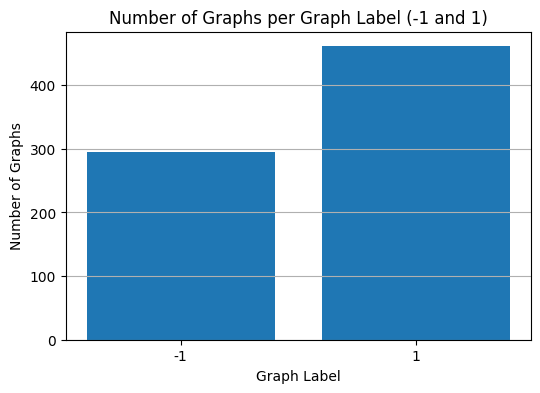

In [ ]:

# Count how many graphs have label -1 and 1
label_counts = graph_labels['graph_label'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6, 4))
plt.bar(label_counts.index.astype(str), label_counts.values)
plt.xlabel('Graph Label')
plt.ylabel('Number of Graphs')
plt.title('Number of Graphs per Graph Label (-1 and 1)')
plt.grid(axis='y')
plt.show()


In [23]:
# ========== Prepare Graphs ==========
# Map each graph_id to its nodes
graph_id_to_nodes = graph_indicator.reset_index().groupby('graph_id')['index'].apply(list).to_dict()

# Create NetworkX graphs per graph
graphs = {}
for graph_id, nodes in graph_id_to_nodes.items():
    # filter edges where both nodes are in the graph
    node_set = set(nodes)
    edges = edge_list[
        edge_list['source'].isin(node_set) & edge_list['target'].isin(node_set)
    ]
    G = nx.Graph()
    G.add_edges_from(edges.values)
    graphs[graph_id] = G

In [34]:
# ========== Compute Graph Metrics ==========
def compute_graph_metrics(G):
    # Density
    density = nx.density(G)
    
    # Average clustering coefficient
    clustering = nx.average_clustering(G)
    
    # Shortest Path Information Distance (SPID)
    if nx.is_connected(G):
        spid = nx.average_shortest_path_length(G)
    else:
        # If disconnected, take largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc)
        spid = nx.average_shortest_path_length(subgraph)

    # Graph size
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    
    return density, clustering, spid, num_nodes, num_edges

In [35]:
# Compute metrics for all graphs
graph_metrics = []
for graph_id, G in graphs.items():
    density, clustering, spid, num_nodes, num_edges = compute_graph_metrics(G)
    label = graph_labels.iloc[graph_id - 1]['graph_label']  # graph_id is 1-indexed
    graph_metrics.append({
        'graph_id': graph_id,
        'density': density,
        'clustering': clustering,
        'spid': spid,
        'num_nodes': num_nodes,
        'num_edges': num_edges,
        'label': label
    })

metrics_df = pd.DataFrame(graph_metrics)



In [36]:


print("Sample metrics:")
print(metrics_df.head())
print(metrics_df.describe())
print(metrics_df.tail())

Sample metrics:
   graph_id   density  clustering      spid  num_nodes  num_edges  label
0         1  0.073892         0.0  4.660099         29         30      1
1         2  0.073892         0.0  4.660099         29         30      1
2         3  0.083077         0.0  4.409231         26         27      1
3         4  0.064394         0.0  5.166667         33         34      1
4         5  0.055331         0.0  5.973009         39         41      1
         graph_id     density  clustering        spid   num_nodes   num_edges  \
count  756.000000  756.000000       756.0  756.000000  756.000000  756.000000   
mean   378.500000    0.055260         0.0    6.095559   41.427249   43.544974   
std    218.382692    0.015246         0.0    0.961020    9.062476    9.254422   
min      1.000000    0.029814         0.0    3.578947   19.000000   20.000000   
25%    189.750000    0.045328         0.0    5.579768   36.000000   38.000000   
50%    378.500000    0.052439         0.0    6.134792   41.0

In [37]:
# ========== Statistical Analysis ==========
# Separate by label
metrics_pos = metrics_df[metrics_df['label'] == 1]
metrics_neg = metrics_df[metrics_df['label'] == -1]

# Define metrics to test
metrics_to_test = ['density', 'clustering', 'spid', 'num_nodes', 'num_edges']

print("\nT-tests results:")
for metric in metrics_to_test:
    stat, pval = ttest_ind(metrics_pos[metric], metrics_neg[metric], equal_var=False)
    print(f"{metric}: t-statistic={stat:.3f}, p-value={pval:.3g}")


T-tests results:
density: t-statistic=5.242, p-value=2.08e-07
clustering: t-statistic=nan, p-value=nan
spid: t-statistic=-4.218, p-value=2.8e-05
num_nodes: t-statistic=-4.721, p-value=2.84e-06
num_edges: t-statistic=-4.691, p-value=3.26e-06


Density: Very significant difference. Graphs with label 1 have higher density on average than graphs with -1.
Clustering: Cannot compute, because all graphs have zero clustering coefficients (flat line at 0).
SPID: Very significant difference. Graphs with label -1 have higher SPID (i.e., longer shortest paths) than label 1. We have both a high absolut value in the t-statistic and also a small p-value <0.05 which would suggest rejecting the null hypothesis and assuming that the difference is statistically significant. 

statistical testing only tells us whether the difference in means is unlikely to have occurred by chance, given the sample size and variance.

let's take SPID again: 

In [39]:
import numpy as np

# Filter SPID values by class
spid_1 = metrics_df[metrics_df['label'] == 1]['spid']
spid_minus1 = metrics_df[metrics_df['label'] == -1]['spid']

# Function to summarize a series
def summarize_distribution(values):
    return {
        "min": np.min(values),
        "5th_percentile": np.percentile(values, 5),
        "median": np.median(values),
        "95th_percentile": np.percentile(values, 95),
        "max": np.max(values),
        "mean": np.mean(values),
        "variance": np.var(values),
        "std_dev": np.std(values)
    }

# Summarize both
summary_1 = summarize_distribution(spid_1)
summary_minus1 = summarize_distribution(spid_minus1)

# Print results
print("SPID Distribution for Label 1:")
for k, v in summary_1.items():
    print(f"  {k}: {v:.3f}")

print("\nSPID Distribution for Label -1:")
for k, v in summary_minus1.items():
    print(f"  {k}: {v:.3f}")

# Compute overlap range
overlap_start = max(summary_1["5th_percentile"], summary_minus1["5th_percentile"])
overlap_end = min(summary_1["95th_percentile"], summary_minus1["95th_percentile"])

if overlap_start < overlap_end:
    print(f"\nOverlap in SPID (5th–95th percentile): [{overlap_start:.3f}, {overlap_end:.3f}]")
    # Estimate overlap proportionally
    total_range = max(summary_1["95th_percentile"], summary_minus1["95th_percentile"]) - \
                  min(summary_1["5th_percentile"], summary_minus1["5th_percentile"])
    overlap_range = overlap_end - overlap_start
    overlap_ratio = overlap_range / total_range
    print(f"Overlap accounts for approx. {overlap_ratio:.1%} of the total combined range.")
else:
    print("\nNo overlap detected in 5th–95th percentile range of SPID between the two classes.")

SPID Distribution for Label 1:
  min: 3.579
  5th_percentile: 4.055
  median: 6.067
  95th_percentile: 7.736
  max: 8.727
  mean: 5.982
  variance: 0.986
  std_dev: 0.993

SPID Distribution for Label -1:
  min: 3.579
  5th_percentile: 4.856
  median: 6.236
  95th_percentile: 7.975
  max: 8.488
  mean: 6.273
  variance: 0.771
  std_dev: 0.878

Overlap in SPID (5th–95th percentile): [4.856, 7.736]
Overlap accounts for approx. 73.5% of the total combined range.


Metric
Label 1 (mean ± std): 5.982 ± 0.993
Label -1 (mean ± std): 6.273 ± 0.878
Difference: ~ 0.29

The sample size is relatively large (~120 graphs per group)
The within-group variance is relatively low
The t-test is very sensitive to consistent, even small, mean differences when variance is tight


In [30]:
# ========== Simple Classification ==========
# Prepare data
X = metrics_df[['density', 'clustering', 'spid']].values
y = (metrics_df['label'] == 1).astype(int).values  # 1 if label==1, else 0

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a simple Logistic Regression
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.07      0.13        97
           1       0.59      0.98      0.73       130

    accuracy                           0.59       227
   macro avg       0.64      0.52      0.43       227
weighted avg       0.63      0.59      0.48       227



The logistic regression almost always predicts label 1, because:

    - Recall for 1 is 98% (very high) 

    - Recall for 0 (i.e., label -1) is 7% (almost none)

    - Overall accuracy is ~59%, slightly better than random guessing (but not impressive).

Features (density, SPID) can somewhat separate label 1 graphs but struggle with label -1.

### Takeaway:
Statistical significance does not always imply practical predictive power.

The p-values are tiny, meaning that the difference in averages is not due to chance. Thus on average, the groups are different — but averages don’t tell the full story. Statistical significance tells you about group differences. Classification needs individual-level separation.

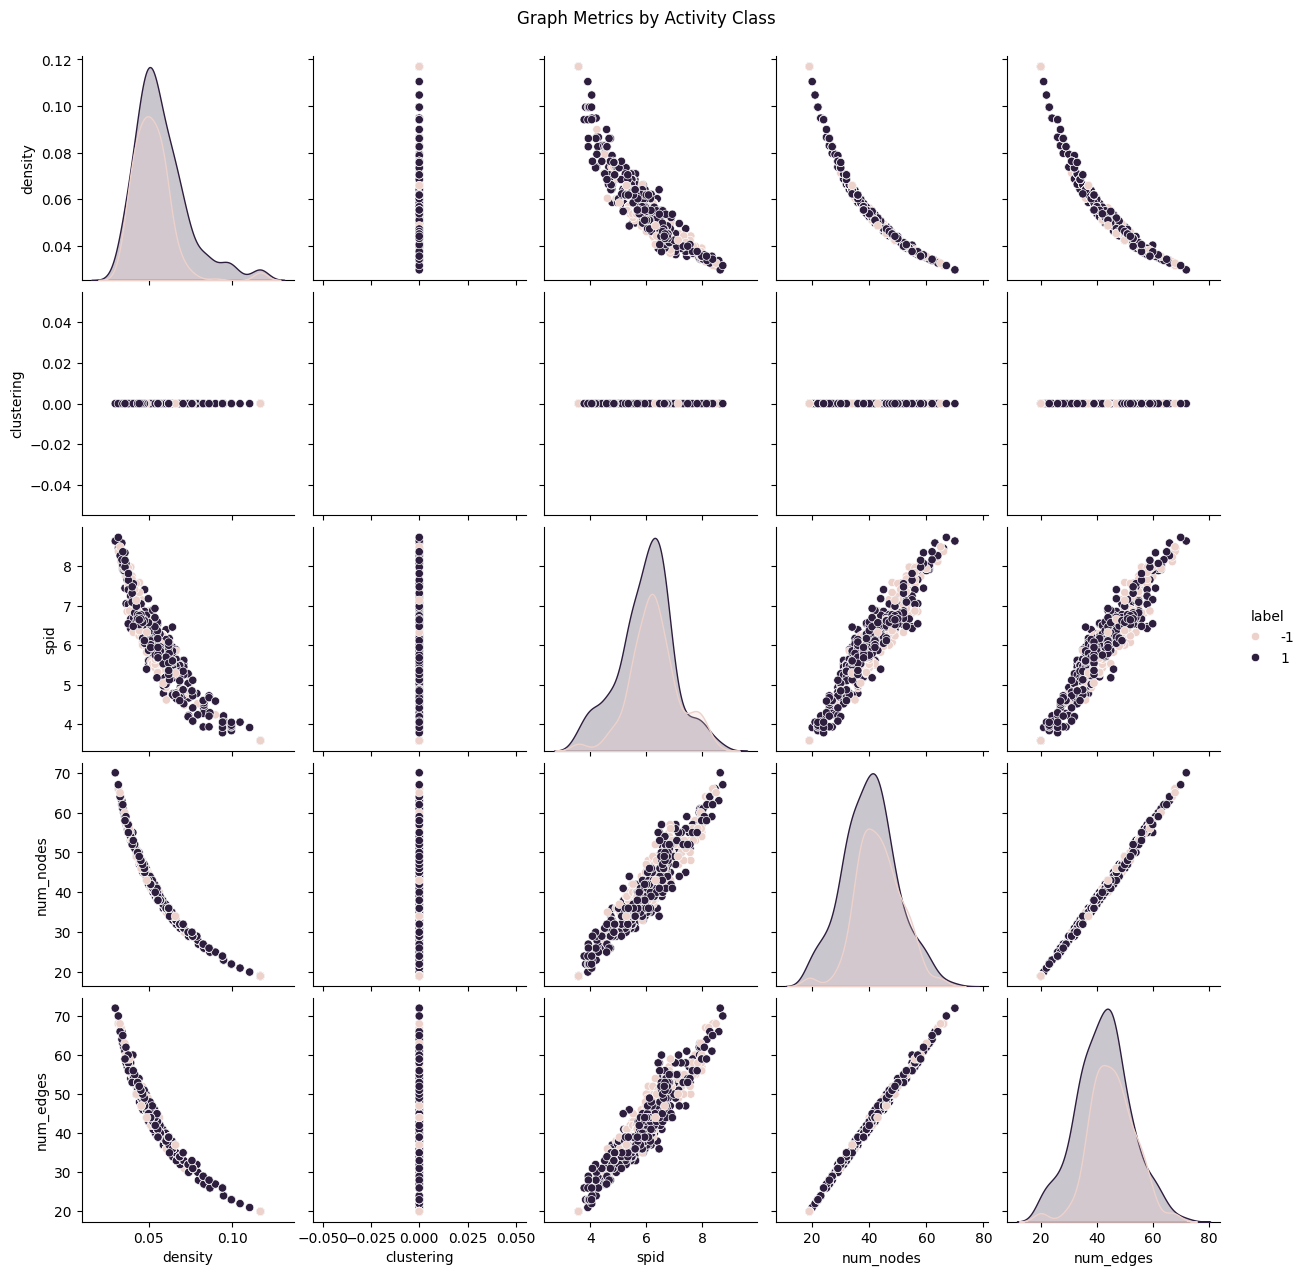

In [38]:
import seaborn as sns
sns.pairplot(metrics_df, hue='label', vars=['density', 'clustering', 'spid', 'num_nodes', 'num_edges'])
plt.suptitle('Graph Metrics by Activity Class', y=1.02)
plt.show()

Diagonal: Distributions (KDE plots) of individual features
Off-diagonal: Scatter plots of feature combinations
## Observations 
1. Clustering coefficient is useless (Shows up as a single vertical or horizontal line)
- No variability → can’t contribute anything to classification or t-tests
2. Density vs. SPID: Strong inverse relationship
- Bottom-left to top-right diagonal trend: as density increases, SPID decreases
- This is intuitive: more connected graphs (higher density) tend to have shorter path lengths (lower SPID)
3. num_nodes and num_edges are strongly correlated (linear)
- Makes sense: more nodes → more potential edges
- Don't use both features in classifier -> this could cause multicollinearity
4. SPID vs. num_nodes / num_edges:
- More nodes → longer SPID
- More edges → shorter SPID (denser connectivity)
- Labels are somewhat (very low) separable:
-> Label -1 (pink) graphs tend to have more nodes, more edges, and longer SPID
-> Label 1 (black) graphs tend to be smaller, denser, and more compact
5. SPID/Density alone partially separates classes
- KDE plots show density/SPID of label 1 graphs is higher than that of label -1 graphs
- There’s some overlap, but the shift is visually clear -> not alone enough for classifier but carries some signal 

## Conclusion: 
None of these features alone can completely separate the classes, but together, they can give predictive signal. Clustering coefficient adds no value in this dataset. 
